# Détecteur de stéréotypes


In [1]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [2]:
# Imports
import json
import os
import re

import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from mistralai import Mistral
from tqdm.auto import tqdm
from pyfonts import load_google_font
from aquarel import load_theme

load_dotenv()
tqdm.pandas()

## Importation et simplification des données


In [3]:
df = pd.read_csv("./dataset/rtbfCorpus.csv", sep="|", encoding="utf-8")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767204 entries, 0 to 767203
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 767204 non-null  int64 
 1   pub_date           767204 non-null  object
 2   feed               767204 non-null  object
 3   category           759930 non-null  object
 4   keyword            644449 non-null  object
 5   signature          763736 non-null  object
 6   title              767202 non-null  object
 7   text_html          767204 non-null  object
 8   text_cleaned       767204 non-null  object
 9   test_preprocessed  767201 non-null  object
dtypes: int64(1), object(9)
memory usage: 58.5+ MB


In [4]:
# Filter the DataFrame for the "MONDE" category
df_monde = df.copy()
df_monde.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767204 entries, 0 to 767203
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 767204 non-null  int64 
 1   pub_date           767204 non-null  object
 2   feed               767204 non-null  object
 3   category           759930 non-null  object
 4   keyword            644449 non-null  object
 5   signature          763736 non-null  object
 6   title              767202 non-null  object
 7   text_html          767204 non-null  object
 8   text_cleaned       767204 non-null  object
 9   test_preprocessed  767201 non-null  object
dtypes: int64(1), object(9)
memory usage: 58.5+ MB


In [5]:
distinct_keywords = df_monde["keyword"].unique()
distinct_keywords


array([nan, 'DIVERS', 'LOISIRS', 'FAITS DIVERS', 'DEFENSE', 'ENERGIE',
       'ENTREPRISES', 'AMERIQUE DU SUD', 'AFRIQUE', 'AMERIQUE DU NORD',
       'JUSTICE', 'ASIE', 'EUROPE', 'SYNDICALISME', 'RELIGION', 'SANTE',
       'POLITIQUE', 'MUSIQUE', 'INTERNET', 'MOYEN ORIENT', 'AGRICULTURE',
       'IMMIGRATION', 'TECHNOLOGIE', 'MOBILITE', 'INSOLITE', 'CINEMA',
       'ECONOMIE', 'TERRORISME', 'AERONAUTIQUE', 'ENVIRONNEMENT',
       'PEOPLE', 'CONSOMMATION', 'DROGUES', 'AMERIQUE CENTRALE',
       'REGION DE BRUXELLES', 'JEUNESSE', 'ENSEIGNEMENT', 'CATASTROPHE',
       'EMPLOI', 'LITTERATURE', 'DEVISES', 'ESPACE', 'CATASTROPHES',
       'SCIENCES', 'BEAUX ARTS', 'AUTOMOBILE', 'MONDE', 'OCEANIE',
       'ANVERS', 'LUXEMBOURG', 'COMMERCE', 'MER', 'LIMBOURG', 'HAINAUT',
       'LIEGE', 'CONFLITS', 'BRABANT WALLON', 'SPECTACLES',
       'FLANDRE ORIENTALE', 'MONARCHIE', 'NAMUR', 'FLANDRE OCCIDENTALE',
       'MARCHES', 'BRABANT FLAMAND'], dtype=object)

In [6]:
keywords_to_filter_out = [
    "AMERIQUE DU SUD",
    "ASIE",
    "AMERIQUE CENTRALE",
    "AMERIQUE DU NORD",
    "REGION DE BRUXELLES",
    "SPECTACLES",
    "OCEANIE",
    "NAMUR",
    "FLANDRE OCCIDENTALE",
    "LIMBOURG",
    "LUXEMBOURG",
    "BRABANT WALLON",
    "BRABANT FLAMAND",
    "FLANDRE ORIENTALE",
    "ANVERS",
    "LIEGE",
    "HAINAUT",
]
mask = df_monde["keyword"].isin(keywords_to_filter_out)
df_monde_restreint = df_monde[~mask]

## Sampling pour protoyper


In [7]:
sr = df_monde_restreint
sr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 740822 entries, 0 to 767203
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 740822 non-null  int64 
 1   pub_date           740822 non-null  object
 2   feed               740822 non-null  object
 3   category           733564 non-null  object
 4   keyword            618067 non-null  object
 5   signature          737356 non-null  object
 6   title              740820 non-null  object
 7   text_html          740822 non-null  object
 8   text_cleaned       740822 non-null  object
 9   test_preprocessed  740819 non-null  object
dtypes: int64(1), object(9)
memory usage: 62.2+ MB


## Stéréotypes


In [8]:
stereotypes = {
    "alep_plus_ancienne_ville": {
        "id": "alep_plus_ancienne_ville",
        "canonical_form": "Alep est la plus ancienne ville du monde.",
        "description": (
            "Idée reçue centrale : Alep serait 'la plus ancienne ville du monde', "
            "présentée comme une cité multimillénaire dont l'habitat continu et "
            "l'ancienneté attesteraient une forme d'exception et de primauté absolue. "
            "L'autrice montre que cette affirmation simplifie les connaissances "
            "archéologiques (compétition avec d'autres sites comme Jéricho, Byblos, Damas), "
            "confond habitat ancien et urbanisation, et ignore les limites de ce que les fouilles "
            "permettent réellement d'affirmer. Elle souligne aussi la manière dont le régime syrien "
            "mobilise cette ancienneté (et plus souvent celle de Damas) dans un récit national et patrimonial."
        ),
        "variants": [
            "Alep est la plus ancienne ville du monde",
            "Alep est la plus vieille ville du monde",
            "Alep est l'une des plus anciennes villes du monde",
            "Alep est la plus ancienne ville habitée au monde",
            "Alep est la plus vieille ville habitée en continu",
            "Alep est une ville multimillénaire",
            "Alep est une cité multimillénaire",
            "Alep est l'une des plus vieilles villes habitées en continu",
        ],
        "mandatory_keywords": [
            "Alep",
            "Syrie",
        ],
        "keywords": [
            "Alep",
            "Halab",
            "Syrie",
            "plus ancienne ville",
            "plus vieille ville",
            "ville la plus ancienne",
            "ville la plus vieille",
            "ville habitée en continu",
            "ville multimillénaire",
            "cité multimillénaire",
            "vieille ville",
            "patrimoine mondial",
            "Unesco",
            "citadelle",
            "ville historique",
            "berceau de la civilisation",
            "civilisations millénaires",
            "Croissant fertile",
            "antiquité",
        ],
        "sub_stereotypes": [
            {
                "id": "syrie_berceau_civilisation",
                "canonical_form": "La Syrie est le berceau immémorial de la civilisation et des plus anciennes villes du monde.",
                "description": (
                    "Idée reçue : la Syrie est présentée comme un 'berceau de la civilisation', "
                    "dotée d'une ancienneté continûment mise en avant (civilisations millénaires, "
                    "villes les plus anciennes, etc.). Ce récit exagère la continuité historique et politique, "
                    "sélectionne certaines découvertes (Alep, Damas) et les utilise comme preuve d'une primauté syrienne "
                    "dans l'histoire universelle, au service d'une narration nationale."
                ),
                "variants": [
                    "La Syrie est le berceau de la civilisation",
                    "La Syrie est le berceau des civilisations",
                    "La Syrie est l'un des plus anciens pays du monde",
                    "Les villes syriennes sont les plus anciennes du monde",
                    "La Syrie est une terre de civilisations millénaires",
                ],
                "keywords": [
                    "Syrie",
                    "berceau de la civilisation",
                    "berceau des civilisations",
                    "civilisations millénaires",
                    "civilisation syro-mésopotamienne",
                    "Croissant fertile",
                    "antiquité",
                    "ville antique",
                ],
            },
        ],
    },
}


## Rôle

Tu es un assistant qui analyse des articles de journaux pour détecter un certain type de stéréotype / idée reçue concernant la Syrie.

Stéréotype à détecter (ID: assad_vs_daech) : **"Le conflit syrien se résume à un duel : soit Assad, soit Daech."**
Description: Assad serait le seul rempart contre Daech. Cette vision binaire efface la pluralité des acteurs (opposition modérée, groupes locaux, factions civiles, Kurdes, islamistes non jihadistes).Elle est souvent mobilisée pour justifier le maintien du régime.

De ce stéréotype découlent d'autres idées reçues analogues:

- **"L'opposition syrienne est fondamentalement islamiste ou jihadiste."** : l'opposition est décrite comme un bloc islamiste, effaçant sa diversité (civile, laïque, minoritaire, armée non jihadiste). Cette vision s'appuie souvent sur des références au Friday protests, au takbîr, ou à l'influence des Frères musulmans.
- **"Il n'existe pas d'opposition syrienne crédible ou significative."** : la révolution syrienne n'a pas produit d'opposition structurée. Cela nie l'existence des comités locaux, de l'Armée syrienne libre, des institutions civiles locales et des cadres politiques du CNS.
- **La révolution syrienne est un soulèvement sunnite confessionnel.** : le conflit syrien serait avant tout confessionnel ou communautaire. En réalité, les revendications initiales étaient politiques, et que des figures minoritaires participèrent au soulèvement.

Variantes possibles de ce stéréotype :

- "C'est Assad ou Daech"
- "Assad est le seul rempart contre Daech"
- "Sans Assad, Daech prendra le pouvoir"
- "Assad ou les terroristes"
- "Assad ou le chaos"
- "Assad ou les islamistes"
- "Il n'y a pas d'alternative à Assad"
- "Entre Assad et Daech il n'y a rien"
- "Le régime protège la Syrie du terrorisme"

## Tâche

Je te donne un article de journal. Tu dois l'analyser et identifier si le stéréotype ci-dessus est présent, si oui sous quelle forme, et pourquoi.
Réponds STRICTEMENT au format JSON suivant (sans texte additionnel) :

```json
{
  "stereotype_id": "assad_vs_daech",
  "present": "yes" | "no" | "uncertain",
  "mode": "reproduit" | "nuancé" | "critiqué" | "non_pertinent",
  "intensite": "évoqué" | "présent" | "dominant" | "omniprésent" | "non_pertinent",
  "resume": "Très court résumé du contenu de l'article. Trois phrases maximum.",
  "justification": "Courte argumentation quant à la présence du stéréotype dans l'article. Laisser vide si le stéréotype est absent.",
}
```


In [10]:
mandatory_keywords = stereotypes["alep_plus_ancienne_ville"]["mandatory_keywords"]


def contains_all_mandatory(text, keywords):
    if not isinstance(text, str):
        return False
    for kw in keywords:
        if not re.search(r"\b" + re.escape(kw) + r"\b", text, flags=re.IGNORECASE):
            return False
    return True


sr_keywords = sr[
    sr["text_cleaned"].progress_apply(
        lambda t: contains_all_mandatory(t, mandatory_keywords)
    )
]
sr_keywords.info()

  0%|          | 0/740822 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 1283 entries, 10078 to 766787
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 1283 non-null   int64 
 1   pub_date           1283 non-null   object
 2   feed               1283 non-null   object
 3   category           1283 non-null   object
 4   keyword            1282 non-null   object
 5   signature          1283 non-null   object
 6   title              1283 non-null   object
 7   text_html          1283 non-null   object
 8   text_cleaned       1283 non-null   object
 9   test_preprocessed  1283 non-null   object
dtypes: int64(1), object(9)
memory usage: 110.3+ KB


In [11]:
def count_keywords(text, keywords):
    count = 0
    for kw in keywords:
        # recherche de mots entiers \b...\b (très important)
        if re.search(r"\b" + re.escape(kw) + r"\b", text, flags=re.IGNORECASE):
            count += 1
    return count

In [12]:
all_keywords = set()

for word in stereotypes["alep_plus_ancienne_ville"]["keywords"]:
    all_keywords.add(word.lower())

for sub_stereotype in stereotypes["alep_plus_ancienne_ville"]["sub_stereotypes"]:
    for word in sub_stereotype["keywords"]:
        all_keywords.add(word.lower())

sr_keywords["keyword_count"] = sr_keywords["text_cleaned"].progress_apply(
    lambda t: count_keywords(t, all_keywords)
)


  0%|          | 0/1283 [00:00<?, ?it/s]

/tmp/ipykernel_5507/2244271276.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sr_keywords["keyword_count"] = sr_keywords["text_cleaned"].progress_apply(


In [15]:
MIN_KEYWORDS = 2
sr_ready = sr_keywords[sr_keywords["keyword_count"] >= MIN_KEYWORDS]
sr_ready.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1283 entries, 10078 to 766787
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 1283 non-null   int64 
 1   pub_date           1283 non-null   object
 2   feed               1283 non-null   object
 3   category           1283 non-null   object
 4   keyword            1282 non-null   object
 5   signature          1283 non-null   object
 6   title              1283 non-null   object
 7   text_html          1283 non-null   object
 8   text_cleaned       1283 non-null   object
 9   test_preprocessed  1283 non-null   object
 10  keyword_count      1283 non-null   int64 
dtypes: int64(2), object(9)
memory usage: 120.3+ KB


## LLM


In [16]:
MISTRAL_API_KEY = os.environ.get("MISTRAL_API_KEY")
AGENT_ID = os.environ.get("AGENT_ID")

client = Mistral(api_key=MISTRAL_API_KEY)

In [17]:
def strip_fenced_json(text: str) -> str:
    """
    If `text` is enclosed in triple-backtick fences (optionally with a language
    spec like ```json), return the inner content trimmed; otherwise return the
    trimmed original text.

    Examples:
    - "```json\n{\"a\":1}\n```" -> "{\"a\":1}"
    - "``` \n{\n  \"a\": 1\n}\n```" -> "{\n  \"a\": 1\n}"
    - "{\"a\":1}" -> "{\"a\":1}"
    """
    if not isinstance(text, str):
        return text

    # Accept fences like ```json, ``` json, ```anylang or plain ```
    # Capture everything between the first opening ```... and the last closing ```
    m = re.search(
        r"^\s*```(?:\s*\w+)?\s*[\r\n]?([\s\S]*?)\s*```\s*$", text, flags=re.IGNORECASE
    )
    if m:
        return m.group(1).strip()

    return text.strip()


def parse_fenced_json(text: str):
    """
    Convenience: strip fences then attempt to parse JSON. Raises json.JSONDecodeError
    if the inner text is not valid JSON.
    """
    inner = strip_fenced_json(text)
    return json.loads(inner)

In [18]:
def analyze_article_with_mistral(article_title: str, article_text: str):
    inputs = [
        {
            "role": "user",
            "content": "Title: " + article_title + "\n\nArticle:\n" + article_text,
        }
    ]
    completion_args = {"temperature": 0.7, "max_tokens": 2048, "top_p": 1}
    tools = []

    raw_response = client.beta.conversations.start(
        inputs=inputs,
        model="mistral-small-latest",
        instructions="""## Rôle\n\nTu es un assistant qui analyse des articles de journaux pour détecter un certain type de stéréotype / idée reçue concernant la Syrie.\n\nStéréotype à détecter (ID: `alep_plus_ancienne_ville`) :\n**"Alep est la plus ancienne ville du monde."**\n\n**Description :**\nAlep est présentée comme « la plus ancienne ville du monde » ou « la plus vieille ville habitée en continu », parfois comme une cité multimillénaire unique. Cette affirmation simplifie les connaissances archéologiques (d’autres villes comme Jéricho, Byblos ou Damas revendiquent aussi une très grande ancienneté), confond habitat ancien et urbanisation continue, et ignore les limites de ce que les fouilles permettent réellement d’affirmer. L’ancienneté d’Alep (et plus largement de la Syrie) est souvent mobilisée dans un récit patrimonial et nationaliste : berceau de la civilisation, invention de l’écriture ou de l’alphabet, figures héroïques comme Zénobie, etc.\n\nDe ce stéréotype central découlent plusieurs idées reçues analogues et sous-stéréotypes fréquents dans les discours :\n\n* **"La Syrie est le berceau immémorial de la civilisation et des plus anciennes villes du monde."**\n  La Syrie est décrite comme un « berceau de la civilisation », terre de civilisations millénaires et de villes parmi « les plus anciennes du monde ». Cette narration exagère la continuité historique et sélectionne certaines découvertes pour construire une primauté syrienne dans l’histoire universelle.\n\n\nVariantes possibles de ce stéréotype et formulations analogues (liste non exhaustive) :\n\n* "Alep est la plus ancienne ville du monde"\n* "Alep est la plus vieille ville du monde"\n* "Alep est l’une des plus anciennes villes du monde"\n* "Alep est la plus ancienne ville habitée en continu"\n* "Alep est une cité multimillénaire" / "ville multimillénaire"\n* "Les villes syriennes sont parmi les plus anciennes du monde"\n* "La Syrie est le berceau de la civilisation" / "des civilisations"\n* "La Syrie est l’un des plus anciens pays du monde"\n\nTu dois considérer comme relevant du stéréotype **tout discours qui présente Alep, la Syrie ou ses villes comme détentrices d’une primauté absolue en ancienneté (ville « la plus ancienne », berceau unique de la civilisation**, que ce soit pour reprendre, nuancer ou critiquer ces affirmations.\n\n## Tâche\n\nJe te donne un article de journal. Tu dois l’analyser et identifier si le stéréotype ci-dessus est présent, et si oui sous quelle forme, et pourquoi. Notamment :\n\n* `"present"` : indique si le thème de cette idée reçue (ancienneté exceptionnelle d’Alep / des villes syriennes / berceau de la civilisation) est abordé dans l’article, peu importe que l’article adopte ou critique cette idée.\n\n  * Exemple : si l’article affirme qu’Alep est « la plus ancienne ville du monde », `"present"` doit être `"yes"` (le stéréotype est repris).\n  * Si l’article explique qu’il y a plusieurs candidates au titre de « plus ancienne ville » (Jéricho, Byblos, Damas, Alep, etc.) et que cette compétition est discutable, `"present"` doit aussi être `"yes"` (le stéréotype est bien présent comme objet de discussion, mais mis à distance).\n  * Si l’article insiste sur la grande ancienneté d’Alep ou de la Syrie mais en soulignant l’incertitude scientifique, la pluralité des sites ou les anachronismes, `"present"` doit également être `"yes"` (le stéréotype est présent, mais nuancé ou critiqué).\n\n* `"mode"` : détermine le positionnement de l’article face à l’idée reçue.\n\n  * `"reproduit"` : l’article reprend l’idée d’Alep « plus ancienne ville du monde » (ou des variantes proches sur la primauté absolue de la Syrie) comme vraie ou très probable, sans la questionner sérieusement.\n  * `"nuancé"` : l’article mentionne ces formules ou ce récit patrimonial, mais les met en balance avec des réserves (autres villes aussi anciennes, incertitudes archéologiques, critiques de l’usage politique de ce récit), ou reste ambigu.\n  * `"critiqué"` : l’article remet clairement en cause cette vision (exagération, construction nationaliste, marketing touristique, mythification), la déconstruit ou la relativise (de manière explicite ou implicite).\n  * `"non_pertinent"` : l’article ne traite pas du tout de ce thème, ou le mentionne de manière tellement marginale que ce n’est pas significatif.\n\n* `"intensite"` : détermine à quel point le stéréotype est central dans l’article, quel que soit le positionnement de l’article à son sujet, sur l’échelle suivante :\n\n  * `"évoqué"` : le stéréotype ou ses variantes sont mentionnés brièvement ou en passant (une phrase ou une formule, par exemple « Alep, l’une des plus anciennes villes du monde », sans développement).\n  * `"présent"` : le stéréotype occupe une place notable dans l’article (au moins un paragraphe de développement), mais ce n’est pas le cœur du propos.\n  * `"dominant"` : le stéréotype structure l’argumentation principale de l’article (article centré sur l’ancienneté d’Alep ou de la Syrie, sur son patrimoine multimillénaire, sur l’idée de berceau de la civilisation, etc.).\n  * `"omniprésent"` : l’article est presque entièrement centré sur cette grille de lecture (ou sur sa critique) et revient sans cesse à l’idée de primauté absolue ou à sa remise en cause.\n  * `"non_pertinent"` : le stéréotype n’apparaît pas du tout.\n\nTu dois également fournir :\n\n* `"resume"` : un très court résumé du contenu de l’article (trois phrases maximum).\n* `"justification"` : une courte argumentation expliquant pourquoi tu as choisi ces valeurs pour `"present"`, `"mode"` et `"intensite"` (en t’appuyant sur des passages de l’article, sans les citer intégralement).\n\nRéponds STRICTEMENT au format JSON suivant (sans aucun texte additionnel et sans formatage markdown) :\n\n{\n"stereotype_id": "alep_plus_ancienne_ville",\n"present": "yes" | "no" | "uncertain",\n"mode": "reproduit" | "nuancé" | "critiqué" | "non_pertinent",\n"intensite": "évoqué" | "présent" | "dominant" | "omniprésent" | "non_pertinent",\n"resume": "Très court résumé du contenu de l'article. Trois phrases maximum.",\n"justification": "Courte argumentation quant à la présence du stéréotype dans l'article.",\n}\n""",
        completion_args=completion_args,
        tools=tools,
    )

    print(raw_response)

    try:
        data = parse_fenced_json(raw_response.outputs[0].content)
    except json.JSONDecodeError:
        data = {"error": "json_decode_error", "raw": raw_response}

    return data


In [ ]:
import time
from tqdm.auto import tqdm

# Work on a copy to avoid SettingWithCopyWarning
sr_ready = sr_ready.copy()


def _extract_json_fields(resp):
    """
    resp: dict as returned by analyze_article_with_mistral
    Returns a dict with keys: present, mode, intensite, resume, justification, raw
    """
    out = {
        "present": None,
        "mode": None,
        "intensite": None,
        "resume": None,
        "justification": None,
        "raw": None,
    }

    if resp is None:
        return out

    # If already parsed as dict with expected keys
    if isinstance(resp, dict):
        # direct fields
        for k in ("present", "mode", "intensite", "resume", "justification"):
            if k in resp:
                out[k] = resp.get(k)
        # raw fallback (some errors/functions returned raw JSON string under 'raw' or entire object as string)
        raw = resp.get("raw") or resp.get("response") or None
        if raw and isinstance(raw, str):
            out["raw"] = raw
            # try to parse raw JSON if fields missing
            if any(
                out[k] is None
                for k in ("present", "mode", "intensite", "resume", "justification")
            ):
                try:
                    parsed = json.loads(raw)
                    for k in (
                        "present",
                        "mode",
                        "intensite",
                        "resume",
                        "justification",
                    ):
                        if parsed.get(k) is not None:
                            out[k] = parsed.get(k)
                except Exception:
                    pass
        return out

    # If resp is a string, try to parse
    if isinstance(resp, str):
        out["raw"] = resp
        try:
            parsed = json.loads(resp)
            for k in ("present", "mode", "intensite", "resume", "justification"):
                out[k] = parsed.get(k)
        except Exception:
            pass
        return out

    return out


# Iterate rows sequentially and call Mistral one by one
results_by_index = {}

# configure delay between requests (seconds)
DELAY_BETWEEN_REQUESTS = 0.5

for idx, row in tqdm(
    list(sr_ready.iterrows()), desc="Analyzing with Mistral", total=len(sr_ready)
):
    title = row.get("title", "") or ""
    text = row.get("text_cleaned", "") or ""

    try:
        resp = analyze_article_with_mistral(
            article_title=str(title), article_text=str(text)
        )
        print(f"Title: {title} | Response: {resp}")
    except Exception as e:
        resp = {"error": str(e)}

    results_by_index[idx] = _extract_json_fields(resp)

    # polite delay to avoid overloading the API
    time.sleep(DELAY_BETWEEN_REQUESTS)

# Build columns from results (preserve DataFrame index)
st_present = []
st_mode = []
st_intensite = []
st_resume = []
st_justification = []
st_raw = []

for idx in sr_ready.index:
    r = results_by_index.get(idx, {})
    st_present.append(r.get("present"))
    st_mode.append(r.get("mode"))
    st_intensite.append(r.get("intensite"))
    st_resume.append(r.get("resume"))
    st_justification.append(r.get("justification"))
    st_raw.append(r.get("raw"))

sr_ready["st_present"] = st_present
sr_ready["st_mode"] = st_mode
sr_ready["st_intensite"] = st_intensite
sr_ready["st_resume"] = st_resume
sr_ready["st_justification"] = st_justification
sr_ready["st_raw_response"] = st_raw

# Optionally persist the results (uncomment to save)
# sr_ready.to_parquet("./sr_ready_with_stereotype_analysis.parquet", index=True)


Analyzing with Mistral:   0%|          | 0/1283 [00:00<?, ?it/s]

In [37]:
sr_ready.to_pickle("./output/guerre_complot/3_keywords.pkl")

In [120]:
# concat all .pkl files from ./output into a single DataFrame
output_dir = "./output"
pkl_files = [f for f in os.listdir(output_dir) if f.lower().endswith(".pkl")]

if not pkl_files:
    raise FileNotFoundError(f"No .pkl files found in {output_dir!r}")

dfs = []
for fn in pkl_files:
    path = os.path.join(output_dir, fn)
    try:
        df = pd.read_pickle(path)
        dfs.append(df)
        print(f"Loaded {fn}: {len(df)} rows")
    except Exception as e:
        print(f"Skipping {fn}: {e}")

combined_df = pd.concat(dfs, ignore_index=True)
print(f"Combined dataframe rows: {len(combined_df)}")
combined_df.info()

# save combined result
combined_df.to_pickle(os.path.join(output_dir, "combined_from_output_pickles.pkl"))

Loaded sr_ready_with_stereotype_analysis_4_to_5_min_keywords.pkl: 913 rows
Loaded sr_ready_with_stereotype_analysis_6_min_keywords.pkl: 278 rows
Loaded sr_ready_with_stereotype_analysis_3_keywords.pkl: 731 rows
Combined dataframe rows: 1922
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1922 entries, 0 to 1921
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 1922 non-null   int64 
 1   pub_date           1922 non-null   object
 2   feed               1922 non-null   object
 3   category           1922 non-null   object
 4   keyword            1904 non-null   object
 5   signature          1922 non-null   object
 6   title              1922 non-null   object
 7   text_html          1922 non-null   object
 8   text_cleaned       1922 non-null   object
 9   test_preprocessed  1922 non-null   object
 10  keyword_count      1922 non-null   int64 
 11  st_present         1922 non-null   o

In [3]:
sr_ready = pd.read_pickle("./output/combined_from_output_pickles.pkl")

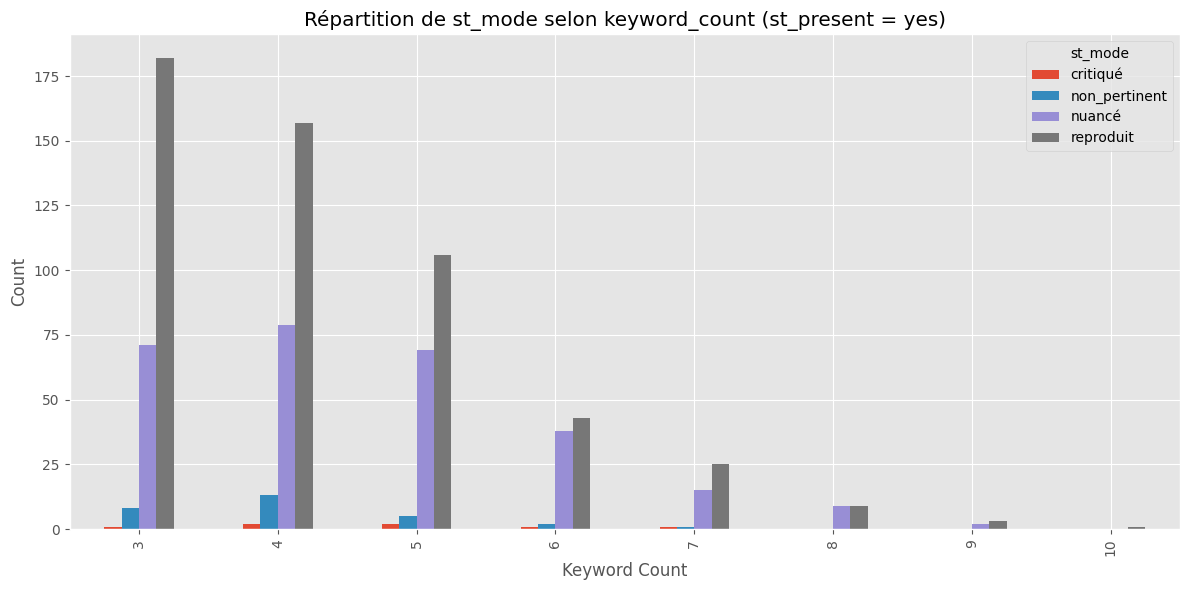

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter rows where st_present == "yes"
filtered = sr_ready[sr_ready["st_present"] == "yes"]

plt.style.use("ggplot")  # Using a matplotlib style as requested

# Create a pivot table for counts
pivot = filtered.pivot_table(
    index="keyword_count", columns="st_mode", aggfunc="size", fill_value=0
)

# Plot
pivot.plot(kind="bar", figsize=(12, 6))

plt.xlabel("Keyword Count")
plt.ylabel("Count")
plt.title("Répartition de st_mode selon keyword_count (st_present = yes)")
plt.tight_layout()

plt.show()


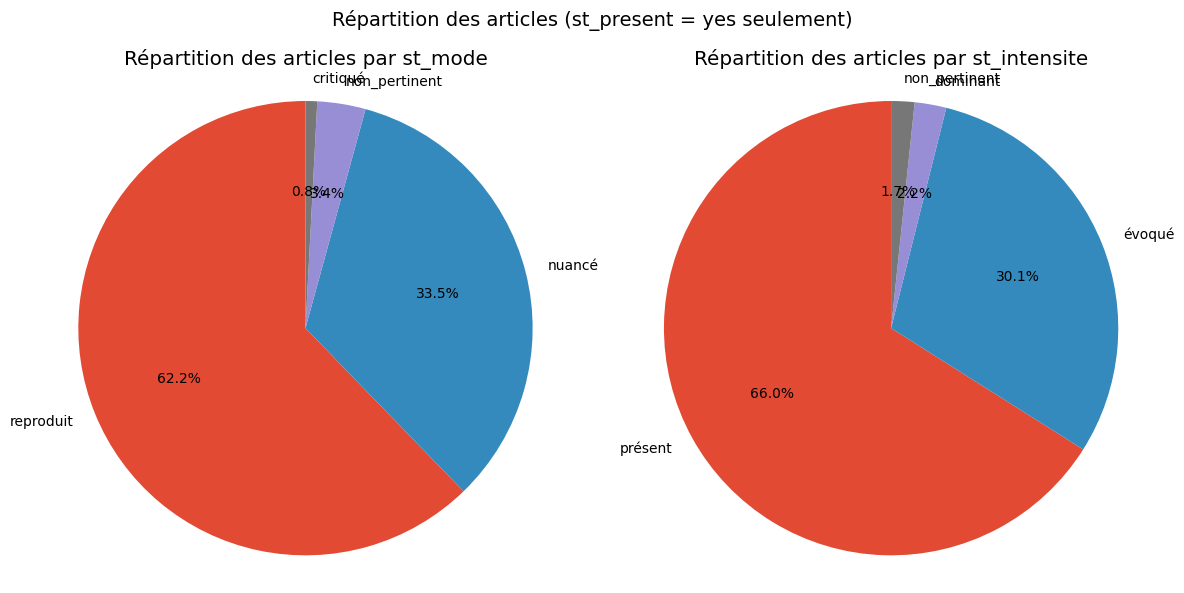

In [125]:
import matplotlib.pyplot as plt
import pandas as pd

# ===== Toggle here =====
# Set to True if you only want rows where st_present == "yes"
# Set to False to use ALL rows
filter_present = True
# =======================

if filter_present:
    df = sr_ready[sr_ready["st_present"] == "yes"].copy()
else:
    df = sr_ready.copy()

plt.style.use("ggplot")  # nice-looking style

# Prepare figure with two pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ---- Pie chart for st_mode ----
mode_counts = df["st_mode"].value_counts()

axes[0].pie(mode_counts, labels=mode_counts.index, autopct="%1.1f%%", startangle=90)
axes[0].set_title("Répartition des articles par st_mode")
axes[0].axis("equal")  # make pie a circle

# ---- Pie chart for st_intensite ----
intensite_counts = df["st_intensite"].value_counts()

axes[1].pie(
    intensite_counts, labels=intensite_counts.index, autopct="%1.1f%%", startangle=90
)
axes[1].set_title("Répartition des articles par st_intensite")
axes[1].axis("equal")

# Overall title, with reminder of filter
filter_label = (
    " (st_present = yes seulement)" if filter_present else " (tous les articles)"
)
fig.suptitle("Répartition des articles" + filter_label, fontsize=14)

plt.tight_layout()
plt.show()


In [46]:
font = load_google_font("Libertinus Serif", danger_not_verify_ssl=True)
print(font)

sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:file=/home/artamis/.cache/pyfontsloader/bed376ccee8533f7b571bc0900cc0cabe1b01d49e723b77d1325da696a5262e0.ttf:size=10.0


In [49]:
def load_arctic_light_with_libertinus():
    """
    Return an aquarel Theme based on 'arctic_light'
    but using Google Fonts 'Libertinus Serif' as the
    default Matplotlib font (loaded via pyfonts).
    """
    # 1) Download & register the Libertinus Serif font from Google Fonts
    libertinus_fp = load_google_font("Libertinus Serif")
    libertinus_name = libertinus_fp.get_name()  # e.g. "Libertinus Serif"

    # 2) Start from the built-in arctic_light theme
    #    and override its font settings to use Libertinus
    theme = load_theme("arctic_light").set_font(
        family="serif",  # use the 'serif' family everywhere
        serif=[libertinus_name],  # and make that family be Libertinus Serif
    )

    # Optionally you can save it for reuse as a JSON theme:
    # theme.save("arctic_light_libertinus.json")

    return theme


In [50]:
theme = load_arctic_light_with_libertinus()
theme.apply()

findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
f

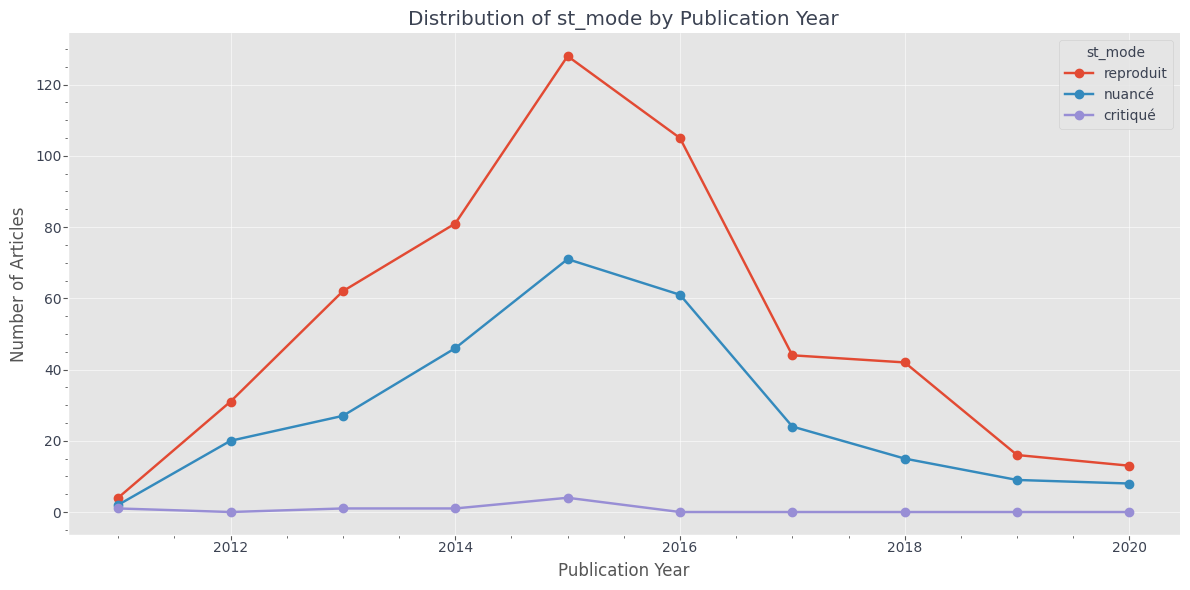

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# Make sure pub_date is datetime
sr_ready["pub_date"] = pd.to_datetime(sr_ready["pub_date"], errors="coerce")

# Extract publication year
sr_ready["pub_year"] = sr_ready["pub_date"].dt.year

# Keep only the 3 main st_mode categories
modes_to_keep = ["reproduit", "nuancé", "critiqué"]
df = sr_ready[sr_ready["st_mode"].isin(modes_to_keep)]

# Count rows per year & st_mode
counts = df.groupby(["pub_year", "st_mode"]).size().unstack(fill_value=0)

plt.style.use("ggplot")
plt.figure(figsize=(12, 6))

# Plot one curve per st_mode
for mode in modes_to_keep:
    if mode in counts.columns:
        plt.plot(counts.index, counts[mode], marker="o", label=mode)

plt.xlabel("Publication Year")
plt.ylabel("Number of Articles")
plt.title("Distribution of st_mode by Publication Year")
plt.legend(title="st_mode")
plt.tight_layout()
plt.show()


In [ ]:
sr_ready = combined_df.copy()
sr_ready.info()
# sr_ready = sr_ready[sr_ready["st_intensite"].isin(["évoqué"])]
# sr_ready = sr_ready[sr_ready["keyword_count"] >= 5]
sr_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1922 entries, 0 to 1921
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 1922 non-null   int64 
 1   pub_date           1922 non-null   object
 2   feed               1922 non-null   object
 3   category           1922 non-null   object
 4   keyword            1904 non-null   object
 5   signature          1922 non-null   object
 6   title              1922 non-null   object
 7   text_html          1922 non-null   object
 8   text_cleaned       1922 non-null   object
 9   test_preprocessed  1922 non-null   object
 10  keyword_count      1922 non-null   int64 
 11  st_present         1922 non-null   object
 12  st_mode            1922 non-null   object
 13  st_intensite       1922 non-null   object
 14  st_resume          1922 non-null   object
 15  st_justification   1922 non-null   object
 16  st_raw_response    0 non-null      object


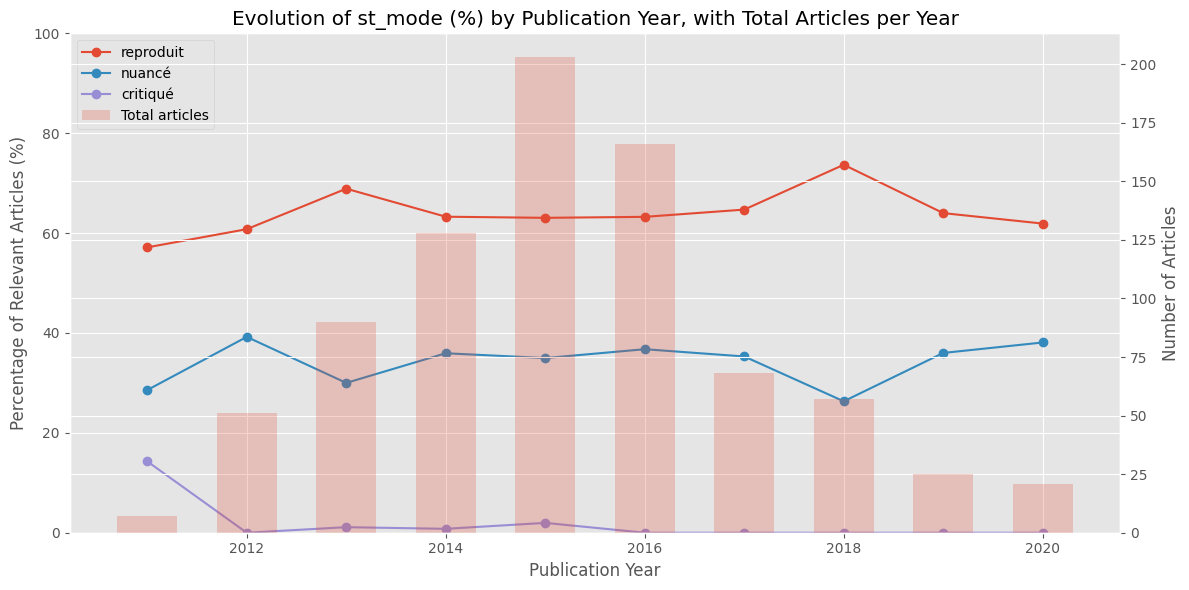

In [153]:
import matplotlib.pyplot as plt
import pandas as pd

# Make sure pub_date is datetime
sr_ready["pub_date"] = pd.to_datetime(sr_ready["pub_date"], errors="coerce")

# Extract publication year
sr_ready["pub_year"] = sr_ready["pub_date"].dt.year

# Keep only the 3 relevant st_mode categories
modes_to_keep = ["reproduit", "nuancé", "critiqué"]
df = sr_ready[sr_ready["st_mode"].isin(modes_to_keep)]

# Count articles per year and st_mode
counts = df.groupby(["pub_year", "st_mode"]).size().unstack(fill_value=0)

# Total relevant articles per year
totals = counts.sum(axis=1)

# Percentages per year
percentages = counts.div(totals, axis=0) * 100

plt.style.use("ggplot")
fig, ax1 = plt.subplots(figsize=(12, 6))

# ---- Percentage curves (left axis) ----
for mode in modes_to_keep:
    if mode in percentages.columns:
        ax1.plot(percentages.index, percentages[mode], marker="o", label=mode)

ax1.set_xlabel("Publication Year")
ax1.set_ylabel("Percentage of Relevant Articles (%)")
ax1.set_ylim(0, 100)

# ---- Bar chart for total articles (right axis) ----
ax2 = ax1.twinx()
ax2.bar(totals.index, totals.values, alpha=0.25, width=0.6, label="Total articles")
ax2.set_ylabel("Number of Articles")

# ---- Legends ----
lines_labels = ax1.get_legend_handles_labels()
bars_labels = ax2.get_legend_handles_labels()
ax1.legend(
    lines_labels[0] + bars_labels[0], lines_labels[1] + bars_labels[1], loc="upper left"
)

plt.title("Evolution of st_mode (%) by Publication Year, with Total Articles per Year")
plt.tight_layout()
plt.show()


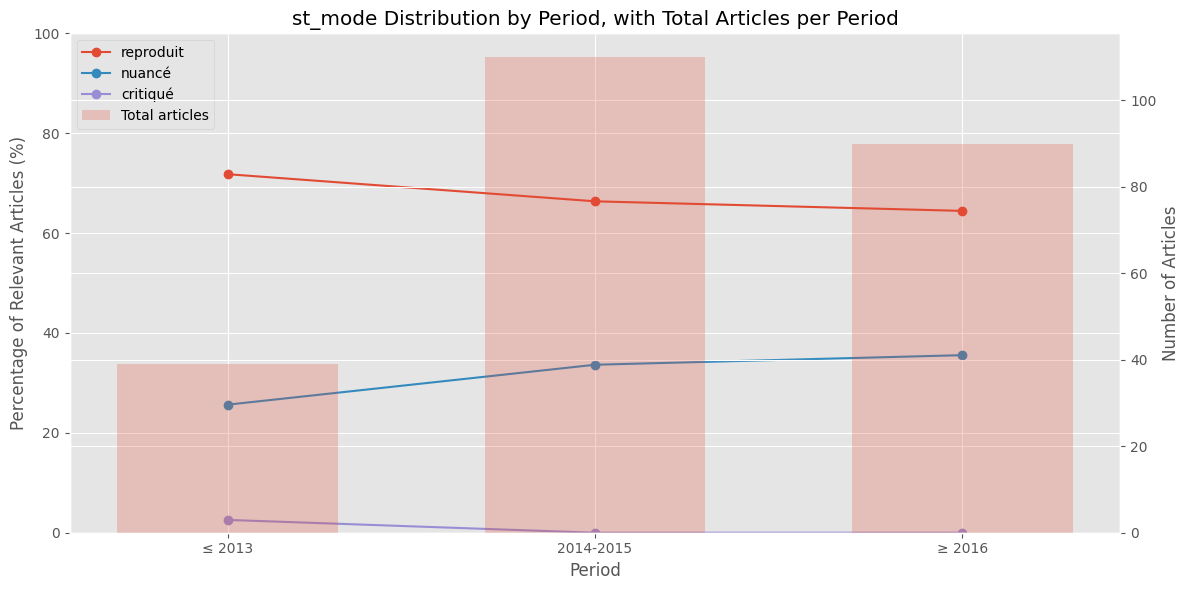

In [150]:
import matplotlib.pyplot as plt
import pandas as pd

# Make sure pub_date is datetime
sr_ready["pub_date"] = pd.to_datetime(sr_ready["pub_date"], errors="coerce")

# Extract publication year
sr_ready["pub_year"] = sr_ready["pub_date"].dt.year


# ----------------------------------------------------
# DEFINE PERIODS HERE — customize as you want
# ----------------------------------------------------
def year_to_period(year):
    if year <= 2013:
        return "≤ 2013"
    elif 2014 <= year <= 2015:
        return "2014-2015"
    else:
        return "≥ 2016"


sr_ready["period"] = sr_ready["pub_year"].apply(year_to_period)
# ----------------------------------------------------

# Keep only the 3 relevant st_mode categories
modes_to_keep = ["reproduit", "nuancé", "critiqué"]
df = sr_ready[sr_ready["st_mode"].isin(modes_to_keep)]

# Count articles per period and st_mode
counts = df.groupby(["period", "st_mode"]).size().unstack(fill_value=0)

# Total relevant articles per period
totals = counts.sum(axis=1)

# Percentages per period
percentages = counts.div(totals, axis=0) * 100

# Ensure periods appear in correct chronological order
period_order = ["≤ 2013", "2014-2015", "≥ 2016"]
percentages = percentages.reindex(period_order)
totals = totals.reindex(period_order)

plt.style.use("ggplot")
fig, ax1 = plt.subplots(figsize=(12, 6))

# ---- Percentage curves (left axis) ----
for mode in modes_to_keep:
    if mode in percentages.columns:
        ax1.plot(percentages.index, percentages[mode], marker="o", label=mode)

ax1.set_xlabel("Period")
ax1.set_ylabel("Percentage of Relevant Articles (%)")
ax1.set_ylim(0, 100)

# ---- Bar chart for total articles (right axis) ----
ax2 = ax1.twinx()
ax2.bar(totals.index, totals.values, alpha=0.25, width=0.6, label="Total articles")
ax2.set_ylabel("Number of Articles")

# ---- Legends ----
lines_labels = ax1.get_legend_handles_labels()
bars_labels = ax2.get_legend_handles_labels()
ax1.legend(
    lines_labels[0] + bars_labels[0], lines_labels[1] + bars_labels[1], loc="upper left"
)

plt.title("st_mode Distribution by Period, with Total Articles per Period")
plt.tight_layout()
plt.show()


In [151]:
# Filter articles with st_mode = "critiqué"
critique_df = sr_ready[sr_ready["st_mode"] == "nuancé"]

print(critique_df)

# Pretty print the relevant columns
for idx, row in critique_df.iterrows():
    print("──────────────────────────────────────────────")
    print(f"TITLE:\n{row['title']}\n")
    print(f"RÉSUMÉ:\n{row['st_resume']}\n")
    print(f"JUSTIFICATION:\n{row['st_justification']}\n")


            id            pub_date      feed category       keyword  \
92     9165825 2015-12-16 09:39:46  RTBFINFO    MONDE        EUROPE   
122    8155070 2013-12-11 11:01:00  RTBFINFO    MONDE  MOYEN ORIENT   
146    8363444 2014-09-25 08:02:00  RTBFINFO    MONDE  MOYEN ORIENT   
147    9627864 2017-06-07 20:46:22  RTBFINFO    MONDE  MOYEN ORIENT   
158    8390677 2014-10-31 08:01:00  RTBFINFO    MONDE  MOYEN ORIENT   
...        ...                 ...       ...      ...           ...   
1846  10341506 2019-10-14 21:49:00  RTBFINFO    MONDE  MOYEN ORIENT   
1888   9110001 2015-10-16 14:51:00  RTBFINFO    MONDE        DIVERS   
1893   9166893 2015-12-17 11:50:00  RTBFINFO    MONDE        EUROPE   
1913  10400956 2020-01-06 20:28:00  RTBFINFO    MONDE  MOYEN ORIENT   
1915  10429908 2020-02-11 09:02:06  RTBFINFO    MONDE        DIVERS   

                  signature  \
92                      AFP   
122          Wahoub Fayoumi   
146   Jean-François Herbecq   
147                    

In [85]:
print(sr_ready.iloc[0]["title"])
print(sr_ready.iloc[0]["st_resume"])
print(sr_ready.iloc[0]["st_justification"])

Liban: journée de deuil national après l'attentat de l'EI ayant fait 43 morts
L'article traite d'un attentat au Liban revendiqué par l'EI, lié au conflit syrien. Le Hezbollah est mentionné pour son soutien au régime de Bachar al-Assad contre les rebelles et les djihadistes en Syrie.
L'article reproduit l'idée reçue en mentionnant que le Hezbollah combat en Syrie aux côtés du régime de Bachar al-Assad contre les djihadistes, impliquant que sans ce soutien, la situation serait pire. Cela efface la diversité des acteurs et la complexité du conflit syrien.


In [17]:
import json
import re
from typing import Any, Dict, List

import requests

OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "mistral:7b"  # or "llama3:8b", "mistral", etc.

In [18]:
stereotype_id = "assad_vs_daech"
stereotype = stereotypes[stereotype_id]

In [ ]:
def analyze_chunk_with_ollama(
    text: str,
    stereotype_id: str,
    stereotype: Dict[str, Any],
    model: str = MODEL_NAME,
    url: str = OLLAMA_URL,
    temperature: float = 0.1,
    timeout: int = 120,
) -> Dict[str, Any]:
    prompt = build_prompt_for_chunk(text, stereotype_id, stereotype)

    payload = {
        "model": model,
        "prompt": prompt,
        "format": "json",  # on demande du JSON directement
        "stream": False,
        "options": {"temperature": temperature},
    }

    resp = requests.post(url, json=payload, timeout=timeout)
    resp.raise_for_status()

    raw_response = resp.json().get("response", "").strip()

    try:
        data = json.loads(raw_response)
    except json.JSONDecodeError:
        data = {"error": "json_decode_error", "raw": raw_response}

    return data


In [ ]:
def analyze_issue_for_stereotype_focus(
    full_text: str,
    stereotype_id: str,
    stereotype: Dict[str, Any],
) -> Dict[str, Any]:
    """
    Analyse un journal (texte complet) pour un stéréotype donné,
    en ne sélectionnant qu'un chunk "focal" autour des mots-clés.

    Retourne :
    - score_presence (ou 0.0 si pas de résultat)
    - mode
    - le chunk utilisé, pour inspection
    - le résultat brut du LLM
    """
    focus_chunk = full_text

    if not focus_chunk.strip():
        return {
            "stereotype_id": stereotype_id,
            "score_presence": 0.0,
            "mode": "non_pertinent",
            "chunk": "",
            "llm_result": None,
        }

    res = analyze_chunk_with_ollama(focus_chunk, stereotype_id, stereotype)

    if isinstance(res, dict) and "score_presence" in res and not res.get("error"):
        return {
            "stereotype_id": stereotype_id,
            "score_presence": res.get("score_presence", 0.0),
            "mode": res.get("mode", "non_pertinent"),
            "chunk": focus_chunk,
            "llm_result": res,
        }
    else:
        return {
            "stereotype_id": stereotype_id,
            "score_presence": 0.0,
            "mode": "non_pertinent",
            "chunk": focus_chunk,
            "llm_result": res,
        }


In [ ]:
stereotype_id = "assad_vs_daech"
stereotype = stereotypes[stereotype_id]


def analyze_row_focus(row):
    text = row["text_cleaned"]
    return analyze_issue_for_stereotype_focus(
        full_text=text,
        stereotype_id=stereotype_id,
        stereotype=stereotype,
    )


sr_keywords["llm_assad_vs_daech"] = sr_keywords.progress_apply(
    analyze_row_focus, axis=1
)

  0%|          | 0/57 [00:00<?, ?it/s]

/tmp/ipykernel_9990/741118110.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sr_keywords["llm_assad_vs_daech"] = sr_keywords.progress_apply(analyze_row_focus, axis=1)


In [50]:
sr_keywords["assad_vs_daech_score"] = sr_keywords["llm_assad_vs_daech"].apply(
    lambda d: d.get("score_presence", 0.0) if isinstance(d, dict) else 0.0
)

sr_keywords["assad_vs_daech_mode"] = sr_keywords["llm_assad_vs_daech"].apply(
    lambda d: d.get("mode", "non_pertinent") if isinstance(d, dict) else "non_pertinent"
)

/tmp/ipykernel_9990/2000915364.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sr_keywords["assad_vs_daech_score"] = sr_keywords["llm_assad_vs_daech"].apply(
/tmp/ipykernel_9990/2000915364.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sr_keywords["assad_vs_daech_mode"] = sr_keywords["llm_assad_vs_daech"].apply(


In [ ]:
sr_assad = sr_keywords.sort_values(by=["assad_vs_daech_score"], ascending=False)

In [67]:
sr_assad.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, 516794 to 706107
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    57 non-null     int64         
 1   pub_date              57 non-null     datetime64[ns]
 2   feed                  57 non-null     object        
 3   category              57 non-null     object        
 4   keyword               55 non-null     object        
 5   signature             57 non-null     object        
 6   title                 57 non-null     object        
 7   text_html             57 non-null     object        
 8   text_cleaned          57 non-null     object        
 9   test_preprocessed     57 non-null     object        
 10  keyword_count         57 non-null     int64         
 11  llm_assad_vs_daech    57 non-null     object        
 12  assad_vs_daech_score  57 non-null     float64       
 13  assad_vs_daech_mod

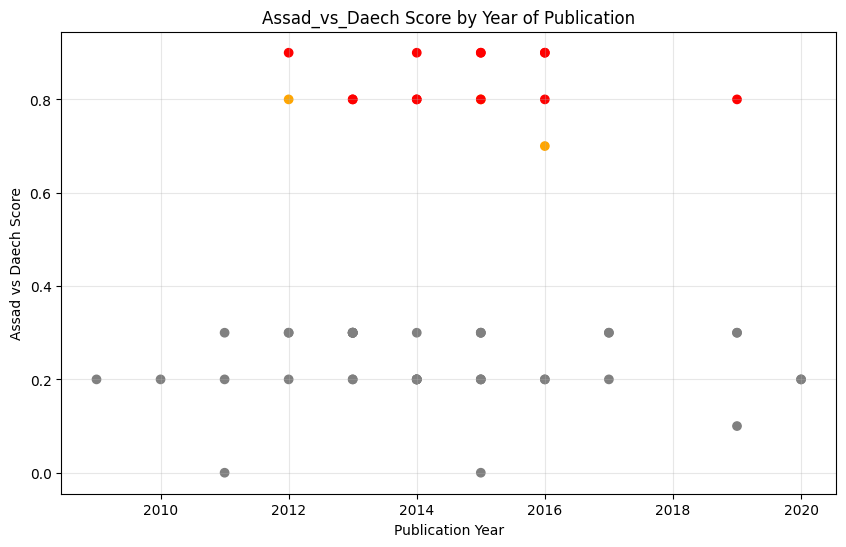

In [ ]:
import matplotlib.pyplot as plt

# Extract publication year
sr_assad["year"] = sr_assad["pub_date"].dt.year

# Color mapping
color_map = {
    "reproduit": "red",
    "nuancé": "orange",
    "critiqué": "green",
    "non_pertinent": "grey",
}

# Assign colors based on the mode
colors = sr_assad["assad_vs_daech_mode"].map(color_map)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(sr_assad["year"], sr_assad["assad_vs_daech_score"], c=colors)

plt.xlabel("Publication Year")
plt.ylabel("Assad vs Daech Score")
plt.title("Assad_vs_Daech Score by Year of Publication")

# Optional: show grid
plt.grid(True, alpha=0.3)

plt.show()


In [77]:
sr_keywords.loc[sr_keywords["assad_vs_daech_mode"] == "nuancé"]["text_cleaned"].iloc[0]

'La coalition internationale antidjihadistes menée par les Etats-Unis a admis samedi avoir bombardé ce qu\'elle pensait être une position du groupe Etat islamique (EI) en Syrie, tuant au moins 60 soldats syriens et provoquant une réunion du Conseil de sécurité de l\'ONU.\n\nLes Etats-Unis ont exprimé samedi leurs "regrets" à la Russie, a dit un responsable de l\'administration Obama. Les Etats-Unis vont continuer d\'observer la trêve en vigueur en Syrie tout en poursuivant leurs opérations militaires contre l\'organisation Etat islamique et Al Qaïda, écrit ce responsable dans un courriel.\n\nUne trêve mise à mal\n\nCe bombardement meurtrier est intervenu au cinquième jour d\'une fragile trêve issue d\'un accord entre les Etats-Unis et la Russie. Dans la foulée, Moscou a accusé samedi soir l\'"opposition modérée" syrienne, soutenue par les Etats-Unis, d\'avoir "fait échouer" ce cessez-le-feu.\n\nCette trêve avait déjà été mise à mal vendredi avec de violents combats et des civils tués d